In [1]:
%reset
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, decomposition
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from pandas import read_csv
import pandas as pd
from matplotlib import style
import seaborn as sns
from sklearn.linear_model import LassoCV

#from sklearn.model_selection import cross_val_score

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
#plotting details
style.use('fivethirtyeight') #who were you expecting?
%config InlineBackend.figure_format = 'png' #'png' goes faster
%matplotlib inline

In [3]:
#def replace_object_with_cat_codes(df):
#given an input dataframe, replace all objects with cat-codes.
#note:building a linear model on top of these now 'numeric' features is 
#not a good idea
def replace_object_with_cat_codes(df):
    cols_obj = df.select_dtypes(['object']).columns
    for i_col in cols_obj:
        df[i_col] = df[i_col].astype('category')
    cat_cols = df.select_dtypes(['category']).columns
    df[cat_cols] = df[cat_cols].apply(lambda x: x.cat.codes)
    return df
#-----
from scipy.stats import skew
#def unskew_cols(df):
#unskew the columns
def unskew_cols(df):
    ind_contin = df.dtypes[df.dtypes !="object"].index
    cont_skew = df[ind_contin].apply(lambda l: skew(l.dropna()))
    cont_skew = cont_skew[cont_skew > .8]
    cont_skew = cont_skew.index
    df[cont_skew] = np.log1p(df[cont_skew])
    return df
#-----
from scipy.stats import f_oneway
#def unskew_cols(df):
#unskew the columns
def prune_category_data_by_anova(data_prune):
    obj_columns = data_prune.select_dtypes(['object']).columns
    l=len(obj_columns)
    i = 0
    list_bad = []
    for col in obj_columns:
        grps = pd.unique(data_prune[col])
        #print grps
        d_data = {grp:data_all['SalePrice'][data_prune[col] == grp] for grp in pd.unique(data_prune[col])}
        f_val, p_val = f_oneway(*d_data.values())  
        if p_val < 0.05:
            i = i +1
            #print("cols of value: %i" % i)        
        else:
            list_bad.append(col)
            data_prune.drop(col,axis=1,inplace=True)
    print("anova pruning reduced to %i columns from %i" % (i,l))
    return (data_prune,list_bad)

# def results(pred,y_test):
# plot the predicted results against the actual results.
def results(pred,y_test):
    rmsle = np.sqrt(np.mean((np.log(pred+1) - np.log(y_test+1))**2))
    rms_error = np.sqrt(np.mean((pred - y_test)**2))
    rms_perc_error = np.sqrt(np.mean(((pred - y_test)/y_test)**2))*100
    plt.plot(y_test,pred,linestyle='None',marker='.',markersize=20)
    plt.xlabel('actual ($)')
    plt.ylabel('predicted ($)')
    plt.axis('equal')
    plt.show()
    print('RMSLE=%.4f RMSE=%.2f; the percent error is %.2f.' % (rmsle, rms_error,rms_perc_error))
    return rmsle
    
# def output_from_log_score(predict,df_all,fname): 
# given 1) results in Log score NOT $ (predict), and 2) the dataframe that has 'Id',
# spit out ['id','predict'] to fname (written as a csv)
def output_from_log_score(predict,df_all,fname):
    pred_val_dollars = np.expm1(predict)
    data_out=pd.DataFrame({"Id": pd.Series(df_all['Id'])})
    data_out['SalePrice']=pd.Series(pred_val_dollars)
    data_out.to_csv(fname,index=False)

In [4]:
data_all = read_csv('train.csv',header=0)
data_test = read_csv('test.csv',header=0)

Step 1: The skip-ahead method

Maybe no processing on the data other than unskewing works fine. Let's try that with a powerful technique, random forests.

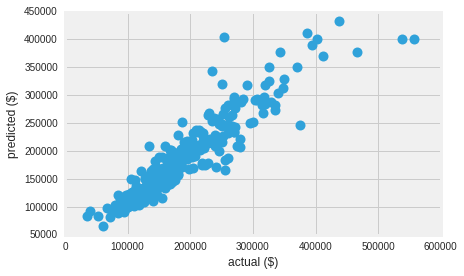

RMSLE=0.1432 RMSE=27564.09; the percent error is 16.80.


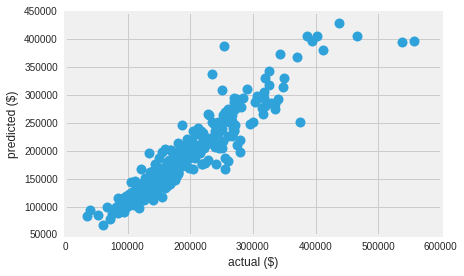

RMSLE=0.1409 RMSE=26809.15; the percent error is 16.58.


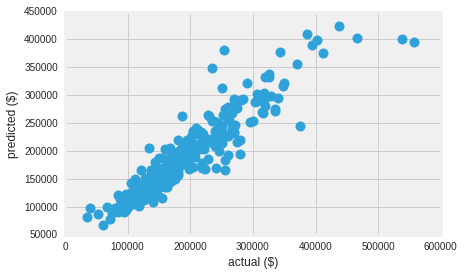

RMSLE=0.1433 RMSE=27304.64; the percent error is 16.91.


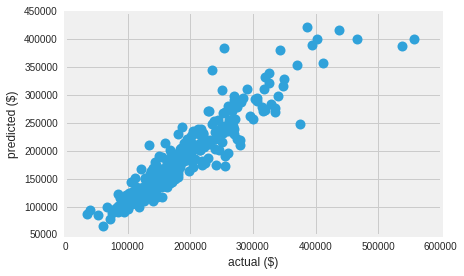

RMSLE=0.1427 RMSE=27128.88; the percent error is 17.02.


In [13]:
data_rf = data_all.copy()
#data_rf = unskew_cols(data_rf)
data_rf = pd.get_dummies(data_rf)
data_rf = data_rf.fillna(data_rf.median())
from sklearn.ensemble import RandomForestRegressor
#hyperparamters: 
# max_features(default=1.0)
# max_depth(pure or <min_samples_split)
# min_samples_split (2)
# min_samples_leaf (1)
X=data_rf;
Y=data_rf['SalePrice']
X.drop('SalePrice',axis=1,inplace=True)
x_train, x_test, y_train, y_test = train_test_split(X,Y)
list_depth = np.arange(30,50,5)
fitrmsle = []
for i_depth in list_depth:
    rf_mod=RandomForestRegressor(max_depth = i_depth, n_estimators=100)
    rf_mod.fit(x_train, y_train)
    pred=rf_mod.predict(x_test)
    pred_dollar = np.expm1(pred)
    y_dollar = np.expm1(y_test)
    #fitrmsle.append(results(pred,y_test)) #for skewed data only
    fitrmsle.append(results(pred_dollar,y_dollar))


The first place to start is a relatively simple regression model of our data. Here we use Lasso regression, which tweaks linear regression by regularizing. That is, we do not just seek to minimize the sum of squares, we also penalize the magnitude of the (absolute value of) coefficients. 

anova pruning reduced to 24 columns from 43
(365, 211)


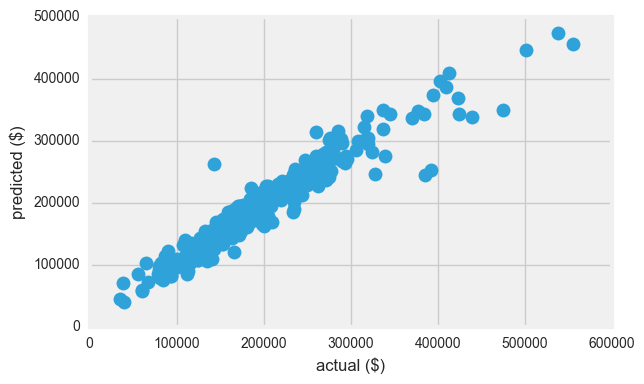

RMSLE=0.1133 RMSE=23283.67; the percent error is 12.16.


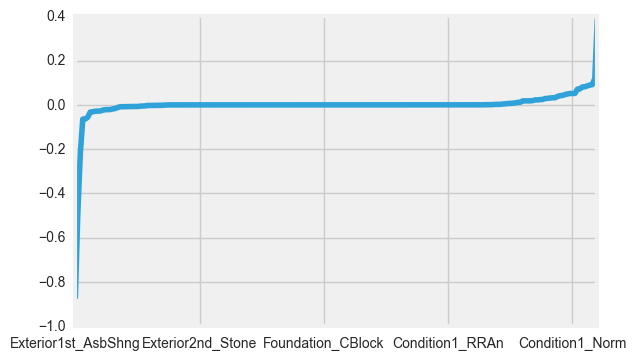

lasso got rid of 118 of 211 variables.


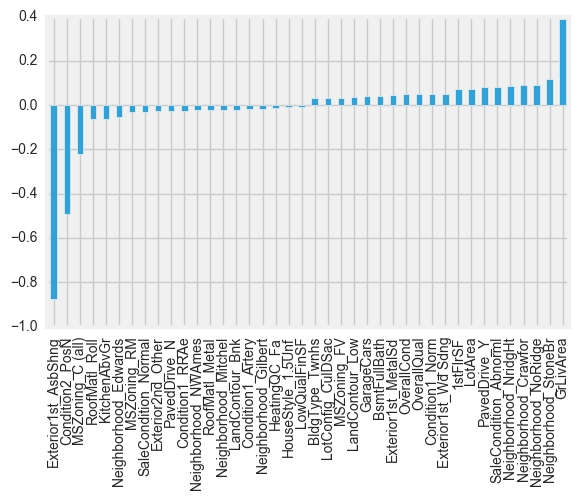

In [39]:
#-----
# def show_lasso_model_cols(model,n):
# graphical display of the best and worst predictors (predictors = 2*n)
#lasso specific: show the best n model columns.
def show_lasso_model_cols(model,cols,n):
    import pandas as pd
    gains=pd.Series(model.coef_,index=cols)
    gains.sort_values().plot()
    plt.show()
    print('lasso got rid of %i of %i variables.' % (sum(gains==0),len(gains)))
    num_best = n
    gains_best_pred=pd.concat([gains.sort_values().head(num_best),gains.sort_values().tail(num_best)])
    gains_best_pred.plot(kind='bar')
#-----
#here is our workflow for the training data:
def data_clean_lasso(df_in):
    df_lasso_all = df_in.copy()                  # make a copy of the original data
    df_lasso = df_lasso_all.loc[:,'MSSubClass':] # ignore the Id
    df_lasso = unskew_cols(df_lasso)             # unskew. we don't know how normal the data are.
    df_lasso,list_bad = prune_category_data_by_anova(df_lasso) # remove cols by anova.
    df_lasso = pd.get_dummies(df_lasso)          # convert categorical data to extra cols.
    df_lasso = df_lasso.fillna(df_lasso.median()) # fill in unknown data with the median.
    return (df_lasso,list_bad)                     # return the new data, and the list.

#-----
def data_clean_lasso_test(df_in,df_model_lasso,list_bad):
# here is our workflow for the test data. 
# it is slightly different because we reject cols based on the previous analysis.
def data_clean_lasso_test(df_in,df_model_lasso,list_bad):
    df_lasso_all = df_in.copy()
    df_lasso = df_lasso_all.loc[:,'MSSubClass':]
    df_lasso = unskew_cols(df_lasso)
    [df_lasso.drop(col,axis=1,inplace=True) for col in list_bad]
    df_lasso = pd.get_dummies(df_lasso)
    df_lasso = df_lasso.fillna(df_lasso.median())    
    df_lasso = add_missing_columns_for_model(df_model_lasso,df_lasso)
    return df_lasso

# def add_missing_columns_for_model(df_complete,df_incomplete):
# it's fair game to have missing columns in your test data.
# this just means that the test data doesn't have all of the categories
# you trained on.
def add_missing_columns_for_model(df_complete,df_incomplete):
    for col in df_complete.columns:
        if col not in df_incomplete.columns:
            xadd = pd.DataFrame(np.zeros([df_incomplete.shape[0],1]), index=np.arange(0,df_incomplete.shape[0]), columns=[col])
            df_incomplete = pd.concat([df_incomplete, xadd], axis=1)
    return df_incomplete

X,list_bad = data_clean_lasso(data_all)
Y = X['SalePrice']
X.drop('SalePrice',axis=1,inplace=True)
x_train, x_test, y_train, y_test = train_test_split(X, Y)
print x_test.shape
lasso_mod=LassoCV(alphas=[1, 0.1, 0.001, 0.0005]).fit(x_train,y_train)
pred = lasso_mod.predict(x_test)
pred_dollars = np.expm1(pred)
y_test_dollars = np.expm1(y_test)
results(pred_dollars,y_test_dollars)

#now generate a prediction
X_TEST = data_clean_lasso_test(data_test,X,list_bad)

TEST_COST = lasso_mod.predict(X_TEST)
output_from_log_score(TEST_COST,data_test,'jerday2.csv')
show_lasso_model_cols(lasso_mod,X_TEST.columns,20)

Note that we have sometimes extremely high negative predictors. RoofMatl_ClyTile and Exterior1st_asbShng are two examples

In [21]:
# Bad predictors.
#we notice that clay tile has an extremely large negative coefficient on it. 
cly=np.where(data_all.RoofMatl=='ClyTile')
cly_test=np.where(data_test.RoofMatl=='ClayTile')
print('The number of samples in the training set with ClyTile is %i' % len(cly))
print('The number of samples in the test set with ClyTile is %i' % len(cly_test))

asb=np.where(data_all.Exterior1st=='asbShng')
asb_test=np.where(data_test.Exterior1st=='asbShng')
print('The number of samples in the training set with asb_shng is %i' % len(asb))
print('The number of samples in the test set with asb_shng is %i' % len(asb_test))


The number of samples in the training set with ClyTile is 1
The number of samples in the test set with ClyTile is 1
The number of samples in the training set with asb_shng is 1
The number of samples in the test set with asb_shng is 1


In [60]:
#what do we want to do? we want to remove columns that are bad
#b=np.where(X.columns==''

In [81]:
def big_errors(pred_dollars,act_dollars,thresh):
    difference = np.abs(pred_dollars-act_dollars)
    i_bad_pred = np.where(difference>thresh)
    #print(i_bad_pred)
    return i_bad_pred[0]


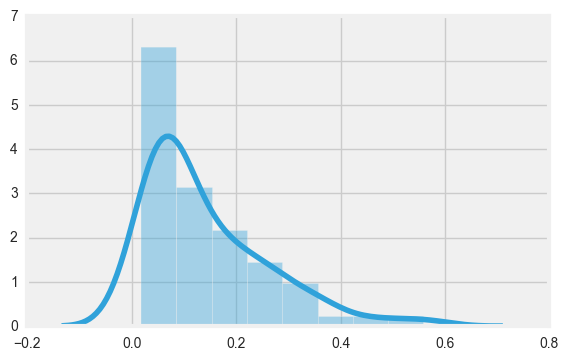

In [96]:
#let's try selecting best x mutual information cols.
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns
mi=mutual_info_regression(x_train,y_train)
sns.distplot(mi)

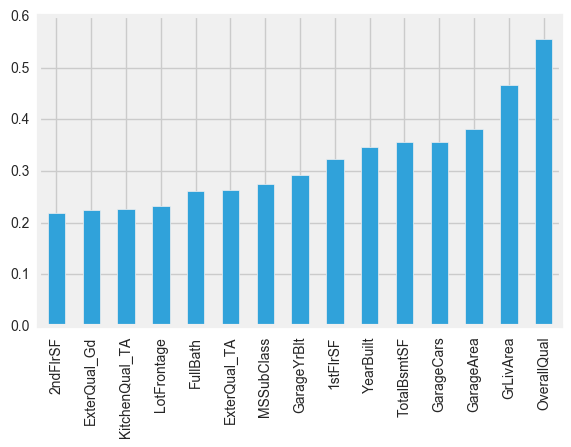

predicting after mutual info prune: 61 vars.


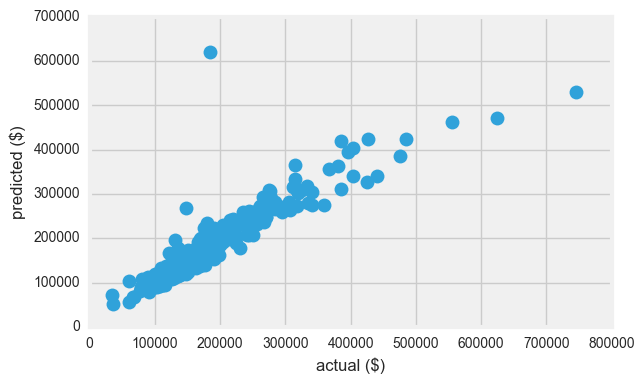

RMSLE=0.1363 RMSE=34659.08; the percent error is 18.25.
(array([ 15,  72,  75, 285, 349]),)
      MSSubClass  LotFrontage    LotArea  OverallQual  OverallCond  YearBuilt  \
1182    4.110874     5.081404   9.656563           10            5       1996   
1324    3.044522     4.330733   9.209040            8            5       2006   
473     3.044522     4.709530   9.614338            8            5       2006   
1169    4.110874     4.779123  10.484613           10            5       1995   
523     4.110874     4.875197  10.599007           10            5       2007   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtUnfSF          ...            \
1182          1996    0.000000    7.648263   5.707110          ...             
1324          2007    6.061457    0.000000   7.493317          ...             
473           2007    5.720312    7.208600   6.440947          ...             
1169          1996    7.229114    7.235619   6.298949          ...             
523           2008   

In [95]:
#show mutual information columns.
def show_mi_cols(mir,cols,n):
    gains=pd.Series(mir,index=cols)
    gains_best_pred=gains.sort_values().tail(n)#this looks weird. but it IS the tail.
    gains_best_pred.plot(kind='bar')
    plt.show()
#arbitrary threshold. 0.04 gets us 53 columns. half of what we've used above.
thresh=.03

X_mi = X.copy()
X_mi = X_mi.loc[:,mi>thresh]
show_mi_cols(mi,X.columns,15)
print("predicting after mutual info prune: %i vars." % X_mi.shape[1])
x_train,x_test,y_train,y_test = train_test_split(X_mi,Y)
lasso_mod=LassoCV(alphas=[1, 0.1, 0.001, 0.0005]).fit(x_train,y_train)
pred = lasso_mod.predict(x_test)
pred_dollars = np.expm1(pred)
y_test_dollars = np.expm1(y_test)
results(pred_dollars,y_test_dollars)
i_bad = big_errors(pred_dollars,y_test_dollars,100000)
print x_test.iloc[i_bad[0],:]

X_TEST = data_clean_lasso_test(data_test,X,list_bad) #this cuts out all of the stuf
X_TEST = X_TEST.loc[:,mi>thresh]

TEST_COST = lasso_mod.predict(X_TEST)
output_from_log_score(TEST_COST,data_test,'jerday_mi.csv')